In [8]:
import ipywidgets as widgets
import pickle
from IPython.display import display, HTML
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np

<Figure size 1200x700 with 0 Axes>

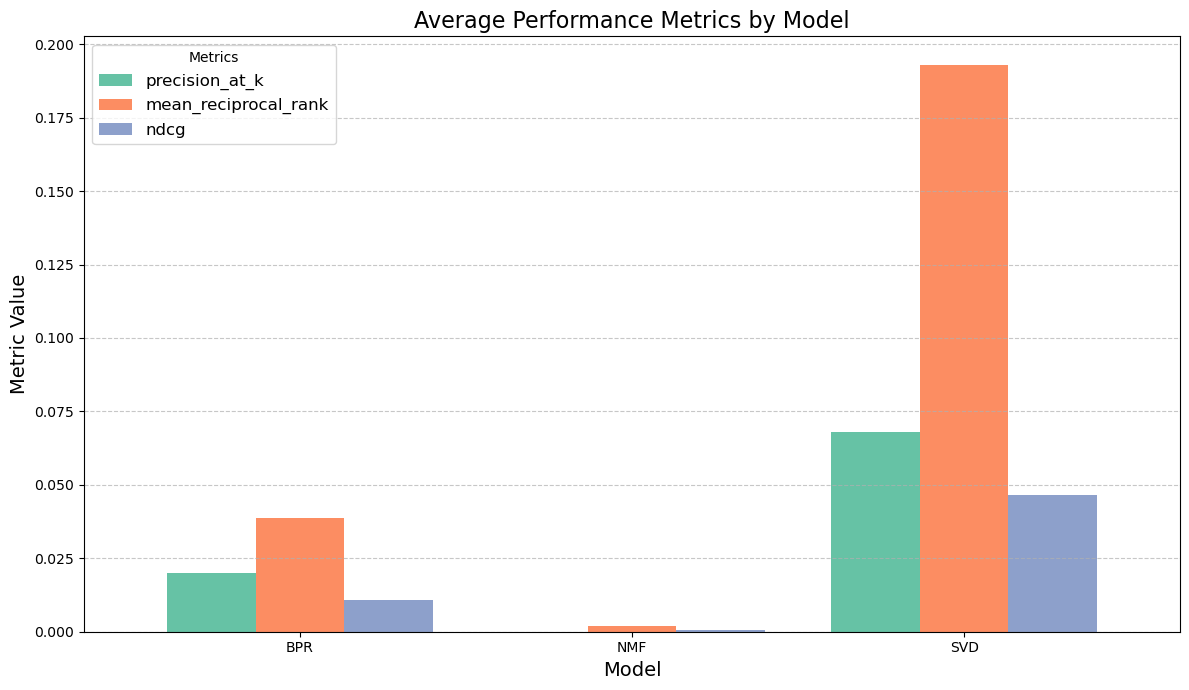

<Figure size 1200x800 with 0 Axes>

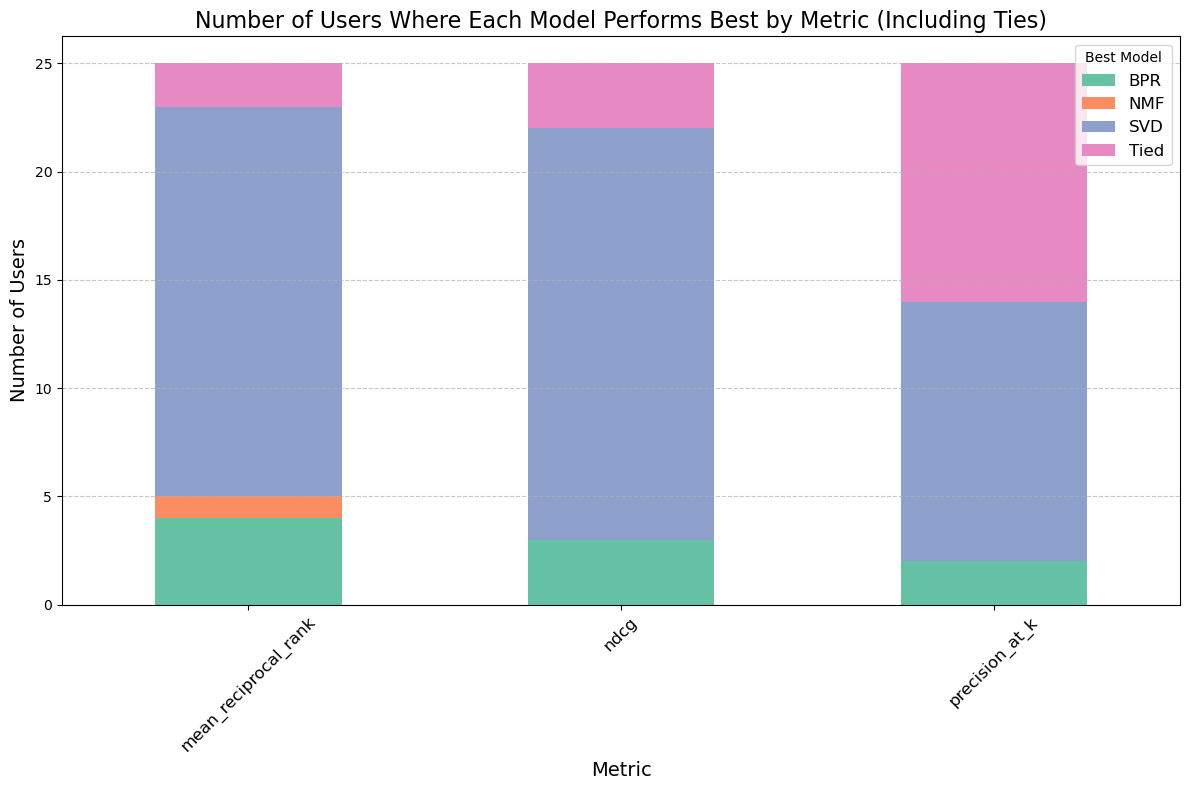

In [9]:
# Load movie data
movies = pd.read_csv('movie_data.csv', quotechar='"', escapechar="\\", on_bad_lines='skip', engine="python")
popularity = pd.read_csv('popular_movies.csv')

popularity = popularity.rename(columns={'title':'movie_title', 'rating': 'overall_rating'})
popularity['rank'] = popularity.index + 1
movies = pd.merge(movies, popularity, on="movie_title", how="inner")

movies.drop_duplicates(subset='movie_id', inplace=True)

# Load model performance from recs.ipynb
metrics_df = pd.read_csv('metrics_results_ranked.csv', index_col=0)

# Drop non-numeric columns before performing groupby operations
#numeric_metrics = metrics_df.drop(columns=['model', 'user'])
numeric_metrics = metrics_df.drop(columns=['user'])

# Calculate average performance by model
grouped_by_model = numeric_metrics.groupby("model").mean()

# Improved Bar Plot for Average Performance by Model
plt.figure(figsize=(12, 7))
grouped_by_model.plot(kind="bar", figsize=(12, 7), width=0.8, color=sns.color_palette("Set2"))
plt.title("Average Performance Metrics by Model", fontsize=16)
plt.ylabel("Metric Value", fontsize=14)
plt.xlabel("Model", fontsize=14)
plt.legend(title="Metrics", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

melted = metrics_df.melt(id_vars=["user", "model"], var_name="metric", value_name="value")

# Step 2: Find the best-performing model(s) for each user and metric
# Group by user and metric, find max value
max_values = melted.groupby(["user", "metric"])["value"].transform("max")
best_performers = melted[melted["value"] == max_values]

# Step 3: Separate ties from the data
# Identify ties (multiple models with the same maximum value)
tie_mask = best_performers.groupby(["user", "metric"])["model"].transform("size") > 1
ties = best_performers[tie_mask]
no_ties = best_performers[~tie_mask]

# Step 4: Count the number of users per model and metric (excluding ties)
model_counts = (
    no_ties.groupby(["metric", "model"])
    .size()
    .unstack(fill_value=0)  # Pivot so each column corresponds to a model
)

# Step 5: Add the number of ties to the results
tie_counts = ties.groupby("metric")["user"].nunique()
model_counts["Tied"] = tie_counts

# Step 6: Ensure total consistency
# Verify the total number of users per metric matches the total number of unique users
total_users_per_metric = melted.groupby("metric")["user"].nunique()
computed_totals = model_counts.sum(axis=1)

# Debugging: Check for discrepancies
if not (computed_totals == total_users_per_metric).all():
    print("Discrepancies detected!")
    print("Total users per metric:")
    print(total_users_per_metric)
    print("Computed totals from model_counts:")
    print(computed_totals)

# Step 7: Plot the results
plt.figure(figsize=(12, 8))
model_counts.plot(kind="bar", stacked=True, figsize=(12, 8), color=sns.color_palette("Set2") + ["grey"])
plt.title("Number of Users Where Each Model Performs Best by Metric (Including Ties)", fontsize=16)
plt.ylabel("Number of Users", fontsize=14)
plt.xlabel("Metric", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.legend(title="Best Model", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [10]:
with open("recommendations.pkl", "rb") as file:
    recommendations = pickle.load(file)

In [11]:
def create_movie_card_grid(movie, algo, rank=None):
    """
    Generates a styled HTML card for a movie.

    Parameters:
    - movie (pd.Series): A row of the movie DataFrame containing metadata.
    - algo (str): The algorithm name (e.g., "SVD", "NMF", "BPR").
    - rank (int, optional): The ranking of the movie for BPR (1 for top recommendation, etc.).

    Returns:
    - card_html (str): HTML string for the movie card.
    """
    movie2 = pd.read_csv('movie_data.csv', quotechar='"', escapechar="\\", on_bad_lines='skip', engine="python")
    # Handle genres column as either a stringified list or a list
    genres = movie2['genres']
    if isinstance(genres, str):  # Stringified list
        try:
            genres = eval(genres)
        except Exception:
            genres = []  # Fallback if eval fails
    elif not isinstance(genres, list):  # Handle unexpected types
        genres = []

    # Generate HTML for genres
    genres_html = ''.join(
        [
            f'<span style="padding:3px 8px; background:#f0f0f0; border-radius:10px; margin:2px; font-size:12px; display:inline-block;">{genre}</span>'
            for genre in genres[:2]
        ]
    )

    # Add a sticker for SVD and NMF ratings or BPR rankings
    sticker_html = ""
    if algo in ["SVD", "NMF"]:
        sticker_html = f"""
        <div style="position:absolute; top:5px; left:5px; background-color:gold; color:black; font-size:14px; font-weight:bold; padding:5px; border-radius:5px; box-shadow:0px 2px 5px rgba(0,0,0,0.3);">
            {movie['predicted_rating']:.1f}
        </div>
        """
    elif algo == "BPR" and rank is not None:
        sticker_html = f"""
        <div style="position:absolute; top:5px; left:5px; background-color:lightblue; color:black; font-size:14px; font-weight:bold; padding:5px; border-radius:5px; box-shadow:0px 2px 5px rgba(0,0,0,0.3);">
            #{rank}
        </div>
        """

    # Generate the movie card HTML
    card_html = f"""
    <div style="width:170px; margin:5px; display:flex; flex-direction:column; align-items:center; background:#f9f9f9; border:1px solid #ddd; border-radius:10px; overflow:hidden; position:relative;">
        {sticker_html}
        <img src="{movie['full_image_url']}" alt="{movie['movie_title']}" style="width:100%; height:auto; display:block;">
        <div style="padding:5px; text-align:center;">
            <h3 style="margin:0; font-size:14px; line-height:1.2;">{movie['movie_title']} ({int(movie['year_released'])})</h3>
            <div style="margin:5px 0;">{genres_html}</div>
        </div>
    </div>
    """
    return card_html

def display_recommendations_with_navigation(movies, recommendations, top_k=10):
    """
    Displays a dropdown-based interface for movie recommendations with navigation buttons for users
    and pagination for algorithm recommendations.

    Parameters:
    - movies (pd.DataFrame): A DataFrame containing movie metadata with the following columns:
        - 'movie_id': Unique identifier for the movie
        - 'movie_title': Title of the movie
        - 'year_released': Year the movie was released
        - 'genres': A list or stringified list of genres
        - 'image_url': Partial or full URL of the movie poster
    - recommendations (dict): A nested dictionary where:
        {
            "User 1": {
                "Algorithm A": [("movie_id1", rating1), ("movie_id2", rating2), ...],
                "Algorithm B": [("movie_id1", rating1), ("movie_id3", rating3), ...]
            },
            "User 2": {
                ...
            }
        }
    - top_k (int): Number of recommendations to display per page (default 10).

    Returns:
    None
    """
    # Add full image URLs to the movies dataset
    base_url = "https://a.ltrbxd.com/resized/"
    query_suffix = "?v=e6bc359a4a"
    movies['full_image_url'] = base_url + movies['image_url'] + ".jpg" + query_suffix

    # User list and initial index
    user_list = list(recommendations.keys())
    current_user_index = widgets.IntText(value=0, description="User Index:", disabled=True)

    # Dropdown for user selection
    user_dropdown = widgets.Dropdown(
        options=user_list,
        value=user_list[0],
        description="User:",
        layout=widgets.Layout(width="300px")
    )

    # Buttons for user navigation
    user_prev_button = widgets.Button(description="Previous User", layout=widgets.Layout(width="120px"))
    user_next_button = widgets.Button(description="Next User", layout=widgets.Layout(width="120px"))

    # Algorithm navigation buttons
    algo_prev_button = widgets.Button(description="Previous Page", layout=widgets.Layout(width="120px"))
    algo_next_button = widgets.Button(description="Next Page", layout=widgets.Layout(width="120px"))
    algo_page_index = widgets.IntText(value=0, description="Page Index:", disabled=True)

    # Output widget to display the recommendations
    output = widgets.Output()

    def update_recommendations(user, page_index=0):
        """Update the recommendations display for the selected user and page."""
        output.clear_output()
        if user:
            with output:
                # Create tabs for algorithms for the selected user
                algorithm_tabs = widgets.Tab()
                algorithm_children = []
                user_recs = recommendations[user]

                for algo, recs in user_recs.items():
                    # Convert recommendations to a DataFrame
                    recs_df = pd.DataFrame(recs, columns=['movie_id', 'predicted_rating'])
                    # Merge with movie metadata
                    merged_data = movies.merge(recs_df, on='movie_id', how='inner')

                    # Sort by predicted_rating in descending order
                    merged_data = merged_data.sort_values(by='predicted_rating', ascending=False)

                    # Get the current page of recommendations
                    start_idx = page_index * top_k
                    end_idx = start_idx + top_k
                    paginated_data = merged_data.iloc[start_idx:end_idx]

                    # Create a grid of movie cards for recommendations (5 movies per row)
                    recs_html = "<div style='display:grid; grid-template-columns:repeat(5, 1fr); gap:2px;'>"
                    for rank, (_, row) in enumerate(paginated_data.iterrows(), start=start_idx + 1):
                        recs_html += create_movie_card_grid(row, algo, rank if algo == "BPR" else None)
                    recs_html += "</div>"

                    # Create a widget for the recommendations grid
                    algo_output = widgets.HTML(value=f"<h3 style='text-align:center;'>{algo}</h3>{recs_html}")
                    algorithm_children.append(algo_output)

                # Set algorithm tabs and their titles
                algorithm_tabs.children = algorithm_children
                for i, algo in enumerate(user_recs.keys()):
                    algorithm_tabs.set_title(i, algo)

                # Display the algorithm tabs
                display(algorithm_tabs)

    def on_user_dropdown_change(change):
        """Handle user selection from the dropdown."""
        user = change.new
        current_user_index.value = user_list.index(user)
        algo_page_index.value = 0
        update_recommendations(user)

    def on_user_prev_button_click(b):
        """Handle Previous User button click."""
        if current_user_index.value > 0:
            current_user_index.value -= 1
            user_dropdown.value = user_list[current_user_index.value]

    def on_user_next_button_click(b):
        """Handle Next User button click."""
        if current_user_index.value < len(user_list) - 1:
            current_user_index.value += 1
            user_dropdown.value = user_list[current_user_index.value]

    def on_algo_prev_button_click(b):
        """Handle Previous Page button click."""
        if algo_page_index.value > 0:
            algo_page_index.value -= 1
            update_recommendations(user_dropdown.value, algo_page_index.value)

    def on_algo_next_button_click(b):
        """Handle Next Page button click."""
        user = user_dropdown.value
        if user:
            user_recs = recommendations[user]
            max_pages = max(len(recs) for recs in user_recs.values()) // top_k
            if algo_page_index.value < max_pages:
                algo_page_index.value += 1
                update_recommendations(user, algo_page_index.value)

    # Link dropdown and buttons to their actions
    user_dropdown.observe(on_user_dropdown_change, names="value")
    user_prev_button.on_click(on_user_prev_button_click)
    user_next_button.on_click(on_user_next_button_click)
    algo_prev_button.on_click(on_algo_prev_button_click)
    algo_next_button.on_click(on_algo_next_button_click)

    # Initialize with the first user and page
    update_recommendations(user_list[0], 0)

    # Display the interface
    display(
        widgets.VBox(
            [
                widgets.HBox([user_prev_button, user_dropdown, user_next_button]),
                widgets.HBox([algo_prev_button, algo_page_index, algo_next_button]),
                output
            ]
        )
    )

# Call the function
display_recommendations_with_navigation(movies.copy(), recommendations)

In [12]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from ipywidgets import widgets

# Load the pickle file
with open('user_data_test.pkl', 'rb') as f:
    user_ratings = pickle.load(f)

# Flatten the data structure
ratings_list = []
for user_id, ratings in user_ratings.items():
    for rating in ratings:
        ratings_list.append({'user_id': user_id, 'movie_id': rating['movie_id'], 'rating': rating['rating_val']})

# Convert to a DataFrame

exclude_list = ['frozen2013']
ratings_df = pd.DataFrame(ratings_list)
ratings_df = ratings_df.loc[~ratings_df['user_id'].isin(exclude_list)]
ratings_df = ratings_df.loc[ratings_df['rating']>0]

# Merge with movies DataFrame
ratings_df = ratings_df.merge(movies, how='left', on='movie_id')

# Compute user statistics
user_stats = ratings_df.groupby('user_id').agg(
    avg_rating=('rating', 'mean'),
    rating_variance=('rating', 'var'),
    rating_count=('rating', 'count'),
    avg_mean_rating=('rating', 'mean'),  # Mean of movie ratings rated by the user
    avg_popularity=('rank', 'mean'),  # Average rank of movies rated by the user
    avg_year=('release_year', 'mean')  # Average release year of movies rated by the user
).reset_index()

# Create a dropdown to select a user
user_dropdown = widgets.Dropdown(
    options=user_stats['user_id'].tolist(),
    description="Select User:",
    layout=widgets.Layout(width="300px")
)

# Output widgets
output_plots = widgets.Output()
output_best_model = widgets.Output()

def update_plots_and_best_model(change):
    """Update the displayed plots and best model for the selected user."""
    output_plots.clear_output()
    output_best_model.clear_output()
    user_id = change.new

    with output_plots:
        stats = user_stats[user_stats['user_id'] == user_id].iloc[0]

        # Create a grid for all columns except user_id
        stat_columns = [col for col in user_stats.columns if col != 'user_id']
        num_plots = len(stat_columns)
        rows = (num_plots + 1) // 2  # Determine the number of rows needed for a 2-column layout
        fig, axs = plt.subplots(rows, 2, figsize=(15, rows * 4))
        axs = axs.flatten() if num_plots > 2 else [axs]  # Ensure axs is always iterable

        for idx, col in enumerate(stat_columns):
            # Plot distribution of the column across all users
            axs[idx].hist(user_stats[col].dropna(), bins=20, color='skyblue', edgecolor='black', alpha=0.7)
            # Mark the selected user's value
            axs[idx].axvline(stats[col], color='red', linestyle='--', linewidth=2, label=f'User {user_id}')
            axs[idx].set_title(f'{col.replace("_", " ").capitalize()} Comparison', fontsize=14)
            axs[idx].set_xlabel(col.replace("_", " ").capitalize(), fontsize=12)
            axs[idx].set_ylabel('Frequency', fontsize=12)
            axs[idx].legend(fontsize=12)
            axs[idx].grid(axis='y', linestyle='--', alpha=0.7)

        # Hide any unused subplots
        for ax in axs[num_plots:]:
            ax.axis('off')

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.suptitle(f'Distributions for User {user_id}', fontsize=16)
        plt.show()

    with output_best_model:
        # Filter metrics for the selected user
        user_metrics = metrics_df[metrics_df['user'] == user_id]

        # Find the best model for each metric
        best_models = {}
        for metric in ['mean_reciprocal_rank', 'ndcg', 'precision_at_k']:
            best_model = user_metrics.loc[user_metrics[metric].idxmax(), 'model']
            best_score = user_metrics[metric].max()
            best_models[metric] = (best_model, best_score)

        # Display the best models
        display(
            widgets.HTML(
                value=f"""
                <h3>Best Models for User {user_id}</h3>
                <table style="border-collapse: collapse; width: 100%; text-align: left;">
                    <thead>
                        <tr style="background-color: #f2f2f2;">
                            <th style="padding: 8px; border: 1px solid #ddd;">Metric</th>
                            <th style="padding: 8px; border: 1px solid #ddd;">Best Model</th>
                            <th style="padding: 8px; border: 1px solid #ddd;">Score</th>
                        </tr>
                    </thead>
                    <tbody>
                        {"".join([
                            f"<tr>"
                            f"<td style='padding: 8px; border: 1px solid #ddd;'>{metric.replace('_', ' ').capitalize()}</td>"
                            f"<td style='padding: 8px; border: 1px solid #ddd;'>{model}</td>"
                            f"<td style='padding: 8px; border: 1px solid #ddd;'>{score:.4f}</td>"
                            f"</tr>"
                            for metric, (model, score) in best_models.items()
                        ])}
                    </tbody>
                </table>
                """
            )
        )

# Link the dropdown to the update function
user_dropdown.observe(update_plots_and_best_model, names='value')

# Initialize the GUI with the first user's plots and best models
if not user_stats.empty:
    user_dropdown.value = user_stats['user_id'].iloc[0]  # Trigger initial display

# Display the interface
display(widgets.VBox([user_dropdown, output_plots, output_best_model]))


/var/folders/5q/cg5pj3d90tlg43_6djqtt05r0000gp/T/ipykernel_67649/3330610555.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_performers["is_tie"] = best_performers.groupby(["user", "metric"])["model"].transform("size") > 1
/var/folders/5q/cg5pj3d90tlg43_6djqtt05r0000gp/T/ipykernel_67649/3330610555.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_performers["final_model"] = best_performers.apply(lambda row: "Tied" if row["is_tie"] else row["model"], axis=1)


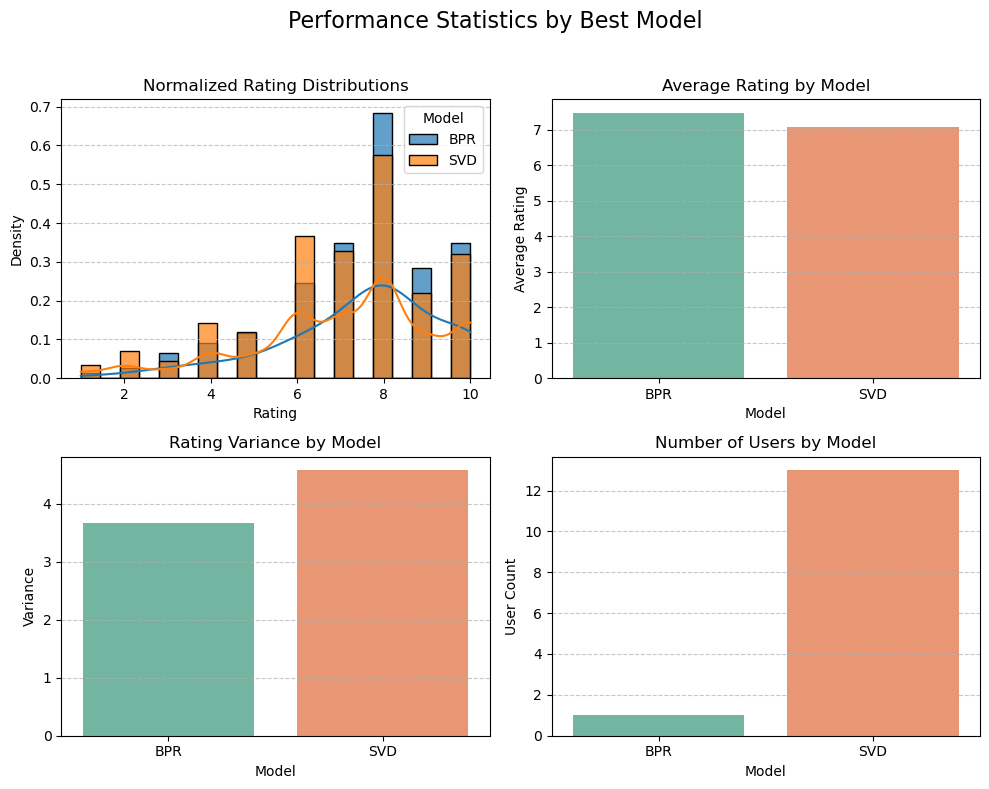

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Reshape metrics data
melted = metrics_df.melt(id_vars=["user", "model"], var_name="metric", value_name="value")
max_values = melted.groupby(["user", "metric"])["value"].transform("max")
best_performers = melted[melted["value"] == max_values]

# Identify ties
best_performers["is_tie"] = best_performers.groupby(["user", "metric"])["model"].transform("size") > 1
best_performers["final_model"] = best_performers.apply(lambda row: "Tied" if row["is_tie"] else row["model"], axis=1)
user_best_model = best_performers.groupby("user")["final_model"].agg(lambda x: x.mode()[0])

# Merge with ratings
ratings_with_model = ratings_df.merge(user_best_model.rename("best_model"), left_on="user_id", right_index=True)

# Exclude tied users
ratings_no_tied = ratings_with_model[ratings_with_model["best_model"] != "Tied"]
group_stats = ratings_no_tied.groupby("best_model").agg(
    avg_rating=("rating", "mean"),
    rating_variance=("rating", "var"),
    user_count=("user_id", "nunique")
).reset_index()

# Create a condensed grid of plots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle("Performance Statistics by Best Model", fontsize=16)

# Plot 1: Normalized Rating Distributions
for model, group in ratings_no_tied.groupby("best_model"):
    sns.histplot(
        group["rating"],
        kde=True,
        stat="density",
        label=model,
        bins=20,
        alpha=0.7,
        ax=axes[0, 0]
    )
axes[0, 0].set_title("Normalized Rating Distributions")
axes[0, 0].set_xlabel("Rating")
axes[0, 0].set_ylabel("Density")
axes[0, 0].legend(title="Model")
axes[0, 0].grid(axis="y", linestyle="--", alpha=0.7)

# Plot 2: Average Rating
sns.barplot(x="best_model", y="avg_rating", data=group_stats, palette="Set2", ax=axes[0, 1])
axes[0, 1].set_title("Average Rating by Model")
axes[0, 1].set_xlabel("Model")
axes[0, 1].set_ylabel("Average Rating")
axes[0, 1].grid(axis="y", linestyle="--", alpha=0.7)

# Plot 3: Rating Variance
sns.barplot(x="best_model", y="rating_variance", data=group_stats, palette="Set2", ax=axes[1, 0])
axes[1, 0].set_title("Rating Variance by Model")
axes[1, 0].set_xlabel("Model")
axes[1, 0].set_ylabel("Variance")
axes[1, 0].grid(axis="y", linestyle="--", alpha=0.7)

# Plot 4: User Count
sns.barplot(x="best_model", y="user_count", data=group_stats, palette="Set2", ax=axes[1, 1])
axes[1, 1].set_title("Number of Users by Model")
axes[1, 1].set_xlabel("Model")
axes[1, 1].set_ylabel("User Count")
axes[1, 1].grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()